# RV Assessment by Kyle Chang

## Preliminary intuition
Before getting started with the technical aspects of this case assessment, I thought it would be useful to go through the intuition on the first question, specifically on which of the variables would or would not be helpful in predicting loan request approval.

To me, the Employment Sector variable would have been helpful in the sense that it's an indicator for income, which directly impacts if a customer can pay off a loan in a timely manner. However, because monthly gross income was already available in the dataset, I found the Employment Sector to be redundant and possibly too correlated with income to be used in statistical models. As a side note, though, if there was additional data on job stability within each Employment Sector, I believe it would be useful information, so I chose to include this in the "Potential Next Steps" portion of this report.

Otherwise, the other variables seemed important in the approval process, so I began with exploring statistical tests to back my intuition up.

## PART 1: Explore the variables' relationships with approvability
### Preprocessing

In [1]:
# import all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# read in the excel dataset and rename the columns to fit the data dictionary
df = pd.read_excel("Pre-Super_Day_candidate_dataset__28candidate_29.xlsx")
df.columns = ["User ID", "Application", "Reason", "Loan Amount", "FICO Score", "FICO Score Group", "Employment Status", "Employment Sector", "Monthly Gross Income", "Monthly Housing Payment", "Ever Bankrupt or Foreclose", "Loaner", "Approved", "Bounty"]
df.head()

,User ID,Application,Reason,Loan Amount,FICO Score,FICO Score Group,Employment Status,Employment Sector,Monthly Gross Income,Monthly Housing Payment,Ever Bankrupt or Foreclose,Loaner,Approved,Bounty
0,00007820-89cb-4c1d-9940-eb270d605a35,1,cover_an_unexpected_cost,100000,669,fair,full_time,consumer_discretionary,5024,927,0,B,0,0
1,00012b55-514c-421e-9c76-3300abbc1134,1,credit_card_refinancing,70000,594,fair,full_time,information_technology,5764,1177,0,B,0,0
2,000157c1-b6a3-4c86-82c7-9ec1bda3799a,1,home_improvement,10000,596,fair,full_time,information_technology,4017,1487,0,A,0,0
3,00020400-efab-4b10-8812-2a0aaf774841,1,home_improvement,100000,642,fair,part_time,energy,3129,904,0,A,0,0
4,0002f737-0cda-48fb-91ed-533f3d0eab05,1,major_purchase,30000,642,fair,full_time,energy,4220,1620,0,A,0,0


In [2]:
# summary statistics to find null values
print(df.info())
print("\nSummary Statistics:")
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   User ID                     100000 non-null  object
 1   Application                 100000 non-null  int64 
 2   Reason                      100000 non-null  object
 3   Loan Amount                 100000 non-null  int64 
 4   FICO Score                  100000 non-null  int64 
 5   FICO Score Group            100000 non-null  object
 6   Employment Status           100000 non-null  object
 7   Employment Sector           93593 non-null   object
 8   Monthly Gross Income        100000 non-null  int64 
 9   Monthly Housing Payment     100000 non-null  int64 
 10  Ever Bankrupt or Foreclose  100000 non-null  int64 
 11  Loaner                      100000 non-null  object
 12  Approved                    100000 non-null  int64 
 13  Bounty                      10

Here, I found about 6500 missing values in the Employment Sector column. From a look at the dataset, these NaNs seem to only appear for unemployed customers.

The following code, however, shows one customer working full time but with a missing value in their Employment Sector column. Since this column was yet to be considered as a significant variable, I decided to wait until the statistical tests were conducting rather than handle it now.

In [3]:
# Shows if every unemployed customer has an NA in Employment Sector

mask = df['Employment Status'] == "unemployed"
result = df.loc[mask, 'Employment Sector'].isna().all()
result

True

In [4]:
# show all customers who are unemployed but have an employment sector
df1 = df[(df['Employment Status'] == "unemployed") & (df['Employment Sector'].notna())] 
# show all customers who are employed but have no employment sector
df2 = df[(df['Employment Status'] != "unemployed") & (df['Employment Sector'].isna())]
df1
df2

,User ID,Application,Reason,Loan Amount,FICO Score,FICO Score Group,Employment Status,Employment Sector,Monthly Gross Income,Monthly Housing Payment,Ever Bankrupt or Foreclose,Loaner,Approved,Bounty
35863,5bee65cd-1b4f-4485-b6ce-c32b42df283c,1,debt_conslidation,20000,585,fair,full_time,NaN,5610,741,0,A,0,0


### Statistical Tests for significance
To test significance of the variables, I chose to use t-tests and Chi-square tests.

In [5]:
def perform_t_test(df, column):
    approved = df[df['Approved'] == 1][column]
    not_approved = df[df['Approved'] == 0][column]
    stat, p = stats.ttest_ind(approved, not_approved)
    result = ""
    if p < 0.05:
        result = f"Statistically Significant"
    else:
        result = f"NOT Statistically Significant"
    print(f"T-test result for {column}:\n   p-value: {round(p, 3)} --> {result}\n")

# Perform t-tests for key numerical variables
numerical_vars = ['FICO Score', 'Monthly Gross Income', 'Monthly Housing Payment', 'Loan Amount']
significance_results = {var: perform_t_test(df, var) for var in numerical_vars}

T-test result for FICO Score:
   p-value: 0.0 --> Statistically Significant

T-test result for Monthly Gross Income:
   p-value: 0.0 --> Statistically Significant

T-test result for Monthly Housing Payment:
   p-value: 0.0 --> Statistically Significant

T-test result for Loan Amount:
   p-value: 0.0 --> Statistically Significant



Above, the t-tests resulted in all continuous variables being statistically significant. This makes sense as FICO score, income, payments, and loan amount are all directly related to the ability for a customer to pay off a loan in a timely manner, which is a main factor of whether or not a customer is approved for a loan.

In [6]:
def perform_chi_square(df, column):
    # Create a contingency table for the categorical variables
    contingency_table = pd.crosstab(df[column], df['Approved'])
    stat, p, dof, expected = stats.chi2_contingency(contingency_table)
    
    result = ""
    if p < 0.05:
        result = f"Statistically Significant"
    else:
        result = f"NOT Statistically Significant"
    
    print(f"Chi-Square test result for {column}:\n   p-value: {round(p, 3)} --> {result}\n")

# Perform Chi-Square tests for categorical variables
categorical_vars = ['Reason', 'FICO Score Group', 'Employment Status', 'Employment Sector', 'Ever Bankrupt or Foreclose']
significance_results_cat = {var: perform_chi_square(df, var) for var in categorical_vars}

Chi-Square test result for Reason:
   p-value: 0.853 --> NOT Statistically Significant

Chi-Square test result for FICO Score Group:
   p-value: 0.0 --> Statistically Significant

Chi-Square test result for Employment Status:
   p-value: 0.0 --> Statistically Significant

Chi-Square test result for Employment Sector:
   p-value: 0.0 --> Statistically Significant

Chi-Square test result for Ever Bankrupt or Foreclose:
   p-value: 0.0 --> Statistically Significant



In the same vein, the Chi-square tests showed that FICO score group and employment status were significant, as well as the Ever Bankrupt or Foreclose boolean column (which makes sense because if a customer has a history of being bankrupt or needing to foreclose their home, it's likely they are not equipped to pay off loans).

However, the tests resulted in the Reason for loan as NOT a statistically significant variable, which means the reason for a loan doesn't contribute much to whether a loan request is approved or not. This is a bit shocking to me, as I believe the reason for a loan request could sway how likely a loan is approved (especially if it's for a more serious reason).

It's also important to note that Employment Sector was actually significant, contrary to what I believed to be the case. But we will look into this a bit more to see if anything else is at play behind the scenes.


In [7]:
categorical_vars = ['Reason', 'FICO Score Group', 'Employment Status', 'Employment Sector', 'Ever Bankrupt or Foreclose']

for var in categorical_vars:
    grouped = df.groupby(var).agg(
        Count=('Approved', 'size'),
        Approval_Rate=('Approved', 'mean')
    ).reset_index()
    print(f"Approval Rate and Count for {var}:")
    print(grouped)
    print("\n")

Approval Rate and Count for Reason:
                     Reason  Count  Approval_Rate
0  cover_an_unexpected_cost  18782       0.109307
1   credit_card_refinancing  17139       0.112667
2         debt_conslidation  27622       0.108935
3          home_improvement  11316       0.109756
4            major_purchase  16023       0.109530
5                     other   9118       0.108138


Approval Rate and Count for FICO Score Group:
  FICO Score Group  Count  Approval_Rate
0        excellent   2188       0.457952
1             fair  36475       0.064373
2             good  27760       0.180620
3             poor  28475       0.027849
4        very_good   5102       0.356527


Approval Rate and Count for Employment Status:
  Employment Status  Count  Approval_Rate
0         full_time  76530       0.120711
1         part_time  17064       0.081224
2        unemployed   6406       0.054948


Approval Rate and Count for Employment Sector:
         Employment Sector  Count  Approval_Rate
0   c

The above code was written to view how the approval rates may vary between the groups of each categorical variable. Hypothetically, if the approval rate varies greatly, then that should indicate a relationship between that variable and loan approvability. For example, the FICO score group varied greatly, with the "excellent" group having an approval rate of close to 50% and the "poor" group having a rate of less thatn 3%. On the contrary, the approval rates for Reason hovered closely around 11% regardless of the reason, which is consistent wiht the Chi-squared test.

/var/folders/6p/16rxddf14jg101l4tlw6vyxw0000gn/T/ipykernel_82040/3441701169.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(sector_stats.index, rotation=45, ha='right')


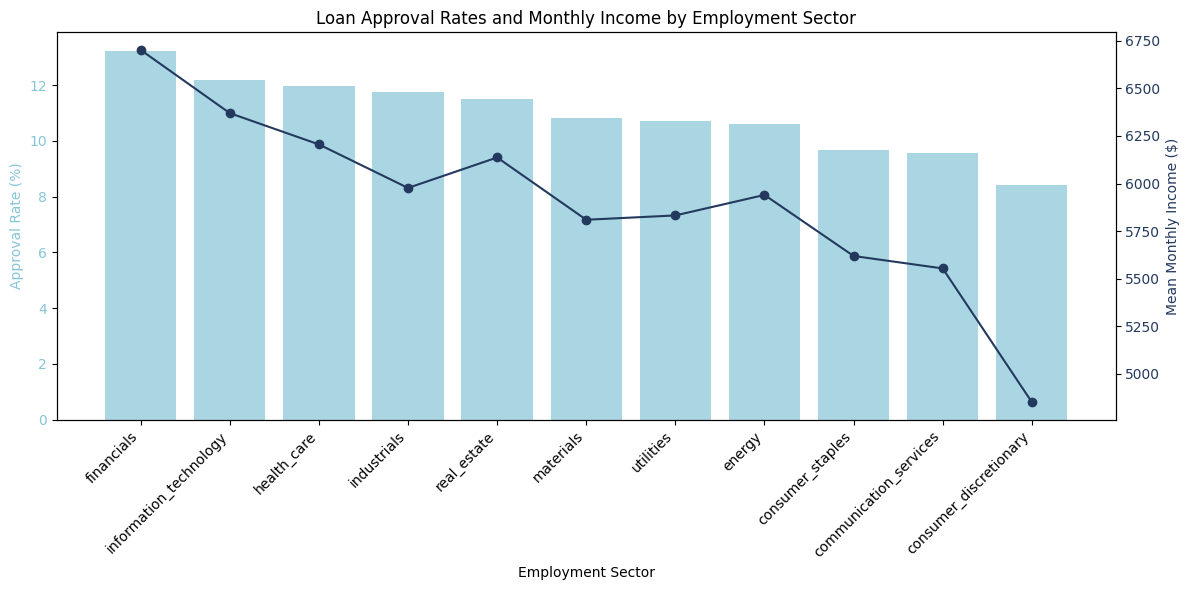

In [8]:
sector_stats = df.groupby('Employment Sector').agg(
    Mean_Monthly_Income=('Monthly Gross Income', 'mean'),
    Approval_Rate=('Approved', lambda x: x.mean() * 100),
    Application_Count=('Approved', 'size')
).sort_values(by='Approval_Rate', ascending=False)

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(sector_stats.index, sector_stats['Approval_Rate'], color='#86C5D8', alpha=0.7)
ax1.set_xlabel('Employment Sector')
ax1.set_ylabel('Approval Rate (%)', color='#86C5D8')
ax1.tick_params(axis='y', labelcolor='#86C5D8')


ax2 = ax1.twinx()
ax2.plot(sector_stats.index, sector_stats['Mean_Monthly_Income'], color='#23395d', marker='o')
ax2.set_ylabel('Mean Monthly Income ($)', color='#23395d')
ax2.tick_params(axis='y', labelcolor='#23395d')

plt.title('Loan Approval Rates and Monthly Income by Employment Sector')
ax1.set_xticklabels(sector_stats.index, rotation=45, ha='right')
plt.grid(False)
plt.tight_layout()
plt.show()

While the Employment Sector column was found to be statistically significant, I suspected that there was a reason behind it, as the result went against my original intuition. To explore this, I graphed the loan approval rates by Employment Sector in a bar chart, while including a line graph of montly income vs. Employment Sector on top of the bar chart. 

This showcased a clear correlation between Employment Sector and Monthly Income, which followed a very similar trend to the one found between Employment Sector and Approval Rates. This is consistent with the idea that some industries have higher incomes than others and therefore different approval rates. So, there is some redundancy in including both Employment Sector and Monthly Income, as they portray the same information.

Furthermore, I ordered the Employment Sectors by approval rate and presented both the mean monthly income of each sector as well as the full time rate. I defined the full time rate to be the percentage of jobs within each sector that were full time. As shown in the table, some industries have proportionally more full time jobs than others, greatly affecting monthly income. Similar to the graph above, the full time rate followed the same trend as the approval rate when measured by Employment Sector.

In [9]:
sector_stats = df.groupby('Employment Sector').agg(
    mean_monthly_income=('Monthly Gross Income', 'mean'),
    approval_rate=('Approved', lambda x: (x.sum() / len(x))),
    count=('Approved', 'size')
).reset_index()

sector_stats_sorted = sector_stats.sort_values(by='approval_rate', ascending=False)

print(sector_stats_sorted, "\n")

employment_status_summary = df.groupby(['Employment Sector', 'Employment Status']).agg(
    employment_status_count=('Employment Status', 'size'),
    approval_rate=('Approved', 'mean')
).reset_index()

df['is_full_time'] = df['Employment Status'].apply(lambda x: 1 if x == 'full_time' else 0)

full_time_summary = df.groupby(['Employment Sector']).agg(
    full_time_rate=('is_full_time', 'mean'),
    approval_rate=('Approved', 'mean')
).reset_index()

full_time_summary_sorted = full_time_summary.sort_values(by='approval_rate', ascending=False)

print(full_time_summary_sorted)

         Employment Sector  mean_monthly_income  approval_rate  count
4               financials          6702.077305       0.132369   9262
7   information_technology          6369.891078       0.122038  19748
5              health_care          6205.490043       0.119729  12403
6              industrials          5976.662654       0.117476   7559
9              real_estate          6136.880499       0.114983   9297
8                materials          5809.441316       0.108328   6748
10               utilities          5832.167549       0.107143   4536
3                   energy          5939.958207       0.106003   5264
2         consumer_staples          5618.986405       0.096835   8974
0   communication_services          5553.552216       0.095718   6655
1   consumer_discretionary          4850.919924       0.084207   3147 

         Employment Sector  full_time_rate  approval_rate
4               financials        0.867523       0.132369
7   information_technology        0.844744

At this point, I got rid of the Employment Sector variable (for its redundancy) and the Reason variable (for its statistical insignificance). I then chose to ignore the FICO Score Group and continued with just the FICO Score, as the continuous version contains more information and would therefore have more predictive power. 

I also chose to combine the Monthly Gross Income and Monthly Housing Payment into a Net Income column (accomplished by subtracting the latter from the former). I felt that this particular combination simplified the data without losing much information from either of the two variables. I see this column as a concise way of representing how much money the customer can use to pay off loans. This comes in handy in the case when two customers have similar income but vastly different housing payments, which can lead to one customer getting a loan approved while the other doesn't. When running the t-test on this new variable, it was still statistically significant with a p-value of 0.

In [10]:
df['Net Income'] = df["Monthly Gross Income"] - df["Monthly Housing Payment"]

significance_results = perform_t_test(df, "Net Income")

T-test result for Net Income:
   p-value: 0.0 --> Statistically Significant



## PART 2: Tell us about the lenders approval rates

For this portion, I checked to see how the approval rates differed by Lender, and to no surprise the approval rate seemed to be related to how much revenue per approval each lender offered BankRate (the higher the revenue, the lower the approval rate).

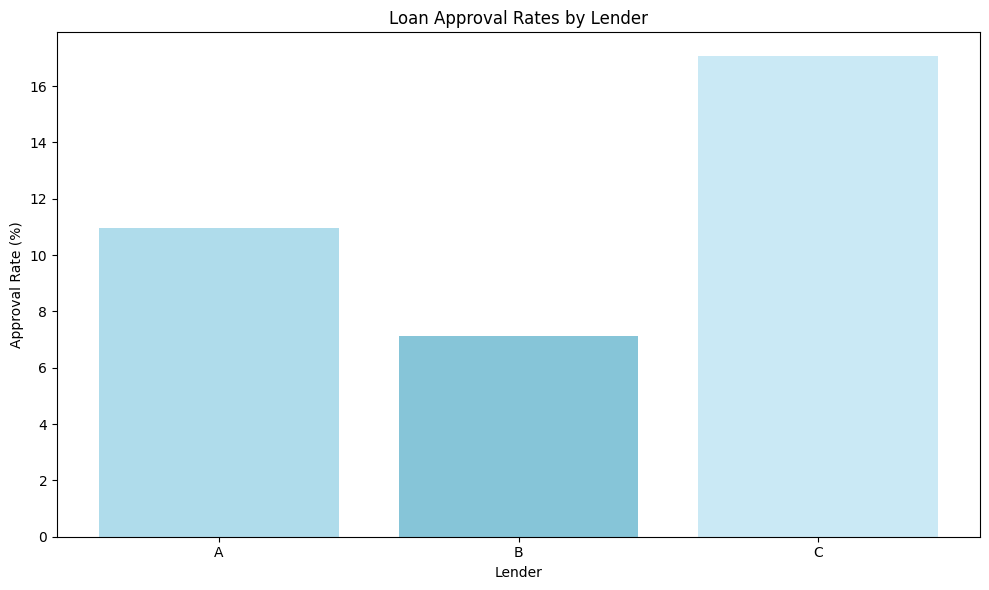

In [ ]:
approval_rates_by_lender = df.groupby('Loaner').agg({
    'Approved': ['mean', 'count']
}).reset_index()
approval_rates_by_lender.columns = ['Lender', 'Approval_Rate', 'Total_Applications']
approval_rates_by_lender['Approval_Rate'] *= 100

plt.figure(figsize=(10, 6))
plt.bar(approval_rates_by_lender['Lender'], 
        approval_rates_by_lender['Approval_Rate'], 
        color=['#AFDCEB', '#86C5D8', '#CAE9F5'])
plt.title('Loan Approval Rates by Lender')
plt.xlabel('Lender')
plt.ylabel('Approval Rate (%)')
plt.tight_layout()
plt.show()

In [27]:
summary_by_loaner_and_approval = df.groupby(['Loaner', 'Approved'])[['Loan Amount', 'FICO Score', 'Net Income', 'Ever Bankrupt or Foreclose']].agg(['mean', 'std']).reset_index()

approved_loaners = summary_by_loaner_and_approval[summary_by_loaner_and_approval['Approved'] == 1]

approved_loaners = approved_loaners.drop(columns=['Approved'])

print(approved_loaners)

  Loaner   Loan Amount                FICO Score              Net Income  \
                  mean           std        mean        std         mean   
1      A  42417.509534  28226.467212  697.358481  74.113488  5809.958879   
3      B  41790.816327  27723.422857  732.108673  53.841987  6359.004082   
5      C  41135.678392  27824.071795  674.770519  81.548255  4977.512228   

               Ever Bankrupt or Foreclose            
           std                       mean       std  
1  3450.792341                   0.005472  0.073775  
3  3249.033300                   0.000000  0.000000  
5  3017.149722                   0.016080  0.125806  


/var/folders/6p/16rxddf14jg101l4tlw6vyxw0000gn/T/ipykernel_82040/1778699548.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  approved_loaners = approved_loaners.drop(columns=['Approved'])


To explore how each lender is different, I aggregated the data by lending parter and displayed the mean and standard deviations for the numerical columns. I chose to only consider borrowers that were approved loans, since that would be more representative of the requirements of each loaner.

Looking at the table above, one thing that I noticed was that the loan amount did not change much between each loaner. This suggest that loan amount doesn't play as much of a role in approvability as do the other numerical variables. These other variables showed a clear pattern, with loaner B requiring a much higher FICO Score and Net Income than loaner C. This is possibly due to the fact that all three loaners have the same loan offer, meaning that the actual loan amounts should generally be the same.

Another thing that I noticed was that for loaner B, the mean and standard deviation of the Ever Bankrupt or Foreclose column were both 0. This meant that in the 100,000 customers in the dataset, every one that was bankrupt or foreclosed their home were essentially barred from getting their request approved by loaner B. 

## PART 3: Evaluate which customers we should match to each lender to maximize Revenue Per Application

### My Proposed Matching System
Given what I now know of (a) which variables are most significant in predicting approvability of loan requests and (b) how each lender differes from another, I came up with a simple yet robust solution to finding an improved matching system that maximizes both company revenue and customer approval rate.

First, the system begins by aggregating the dataset by loaner and training a logistic regression model using the Loan Amount, FICO Score, Net Income, Employment Status, and Ever Bankrupt or Foreclose variables as predictors. During this step, it is essential to use a train-test split to avoid overfitting these models. 

There should now be one model per loaner, based on historical data of customers that applied to the corresponding loaner. Then, for each new customer, run each model and return the predicted probability (the calculated probability that a customer will be approved by the corresponding loaner). After this is done, multiply each probability with the revenue per approval amount that was set by the probability's corresponder loaner. 

The resulting values are the "Expected Revenues," which is the amount that Bankrate could expect to receive from matching a customer to a specific loaner. Now, the system compares these expected revenues and matches the new customer with the loaner with which the expected revenue is the highest.

This system works due to the law of large numbers, where when applied on a large scale of customers and with well trained models, the optimal revenue is sure to be obtained, maximizing Bankrate's revenue and their customers' approval rates. 

### Testing the System

The below code will train models on randomly chosen training data, aggregated by loaner. Then the code is run on testing data, which is an accumulation of the testing data sets from each loaner group. This ensures that no training data is leaked into the testing data, causing an overfit model. The expected revenues that were chosen are then summed up and compared with the total revenue of the current system (original data). Similarly, the probabilities that were chosen are averaged out and compared against the approval rate of the original data.

In [21]:
# Standardizing the numerical columns to avoid certain variables carrying more weight than others
numerical_columns = ['Loan Amount', 'FICO Score', 'Monthly Gross Income', 'Monthly Housing Payment', 'Net Income']
std_df = pd.DataFrame.copy(df)
standard_scaler = StandardScaler()
std_df[numerical_columns] = standard_scaler.fit_transform(df[numerical_columns])

In [22]:
# The proposed system in code

std_df_encoded = pd.get_dummies(std_df, columns=['Employment Status'])

loaners = ['A', 'B', 'C']
probs = pd.DataFrame()
revenue = {'A': 250, 'B': 350, 'C': 150}
features = ['Loan Amount', 'FICO Score', 'Net Income', 'Ever Bankrupt or Foreclose', 'Employment Status_full_time', 'Employment Status_part_time', 'Employment Status_unemployed']
target = 'Approved'
models = {}
test_indices = []

for loaner in loaners:
    loaner_df = std_df_encoded[std_df_encoded['Loaner'] == loaner]
    X_loaner = loaner_df[features]
    y_loaner = loaner_df[target]
    X_train, X_test, y_train, y_test = train_test_split(X_loaner, y_loaner, test_size=0.3, random_state=1)
    test_indices.extend(X_test.index)
    
    model = LogisticRegression(solver='newton-cg')
    model.fit(X_train, y_train)
    models[loaner] = model

test_df = std_df_encoded.loc[test_indices].copy()
probs = pd.DataFrame(index=test_df.index)
exp_revenue = pd.DataFrame(index=test_df.index)

for loaner in loaners:
    probs[loaner] = models[loaner].predict_proba(test_df[features])[:, 1]

for loaner in loaners:
    exp_revenue[loaner] = probs[loaner] * revenue[loaner]

test_df['Categorized Loaner'] = exp_revenue.idxmax(axis=1)  
test_df['Expected Revenue'] = exp_revenue.max(axis=1)  
test_df['Predicted Probability'] = test_df.apply(lambda row: probs.loc[row.name, row['Categorized Loaner']], axis=1)

optimized_total_revenue = test_df['Expected Revenue'].sum()
current_total_revenue = test_df['Bounty'].sum()


print(f"Current Total Revenue: ${current_total_revenue:.2f}")
print(f"Optimized Total Revenue: ${optimized_total_revenue:.2f}")
print(f"Additional Revenue: ${optimized_total_revenue - current_total_revenue:.2f}")
print(f"Percentage Increase in Revenue: {optimized_total_revenue / current_total_revenue * 100 - 100:.3f}% Increase")
print('\n')

current_approval_rate = test_df['Approved'].mean()
optimized_approval_rate = test_df['Predicted Probability'].mean()

print(f"Current Approval Rate: {round(current_approval_rate * 100, 3)}%")
print(f"Optimized Approval Rate: {round(optimized_approval_rate * 100, 3)}%")
print(f"Percentage Increase in Approval Rate: {optimized_approval_rate / current_approval_rate * 100 - 100:.3f}% Increase")

Current Total Revenue: $791100.00
Optimized Total Revenue: $1055411.87
Additional Revenue: $264311.87
Percentage Increase in Revenue: 33.411% Increase


Current Approval Rate: 10.947%
Optimized Approval Rate: 17.946%
Percentage Increase in Approval Rate: 63.941% Increase


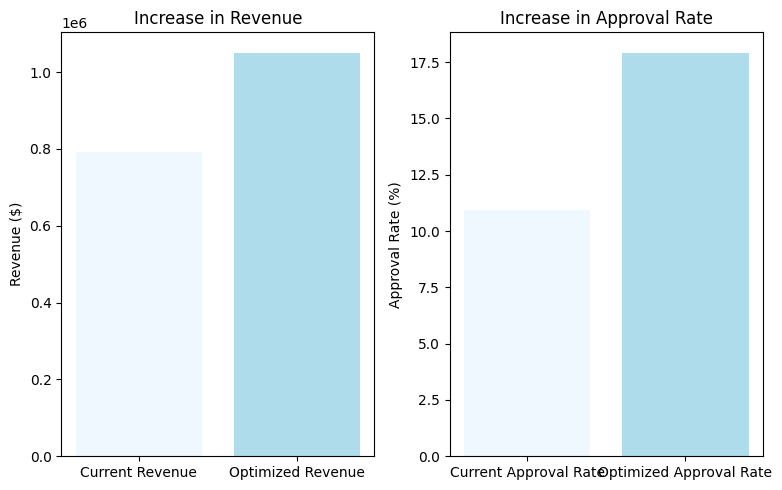

In [16]:
current_revenue = current_total_revenue
optimized_revenue = optimized_total_revenue
current_approval_rate_percent = round(current_approval_rate * 100, 3)
optimized_approval_rate_percent = round(optimized_approval_rate * 100, 3)


plt.figure(figsize=(8, 5))

plt.subplot(1, 2, 1)
plt.bar(['Current Revenue', 'Optimized Revenue'], [current_revenue, optimized_revenue], color=['#F0F8FF', '#AFDCEB'])
plt.title('Increase in Revenue')
plt.ylabel('Revenue ($)')
plt.xticks(rotation=0)


plt.subplot(1, 2, 2)
plt.bar(['Current Approval Rate', 'Optimized Approval Rate'], [current_approval_rate_percent, optimized_approval_rate_percent], color=['#F0F8FF', '#AFDCEB'])
plt.title('Increase in Approval Rate')
plt.ylabel('Approval Rate (%)')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

As shown above, the proposed matching system led to a +33.4% increase in total  revenue and a +63.94% increase in approval rate. This is a significant improvement from the current system. To explore the relationships between the chosen predictors and approvability, below is a look into the coefficients for each model

In [23]:
for loaner in loaners:
    model = models[loaner]
    coef_df = pd.DataFrame({
        'Feature': features,
        'Coefficient': model.coef_[0]
    }).sort_values(by='Coefficient', ascending=False)
    
    print(f"\nCoefficients for Loaner {loaner}:")
    print(coef_df)


Coefficients for Loaner A:
                        Feature  Coefficient
1                    FICO Score     0.960429
6  Employment Status_unemployed     0.266053
2                    Net Income     0.212216
4   Employment Status_full_time     0.011229
0                   Loan Amount    -0.132212
5   Employment Status_part_time    -0.277287
3    Ever Bankrupt or Foreclose    -1.459992

Coefficients for Loaner B:
                        Feature  Coefficient
1                    FICO Score     1.722387
4   Employment Status_full_time     0.679341
5   Employment Status_part_time     0.196007
2                    Net Income     0.142486
0                   Loan Amount    -0.176278
6  Employment Status_unemployed    -0.875349
3    Ever Bankrupt or Foreclose    -1.999817

Coefficients for Loaner C:
                        Feature  Coefficient
1                    FICO Score     0.815807
4   Employment Status_full_time     0.561395
5   Employment Status_part_time     0.140009
2               

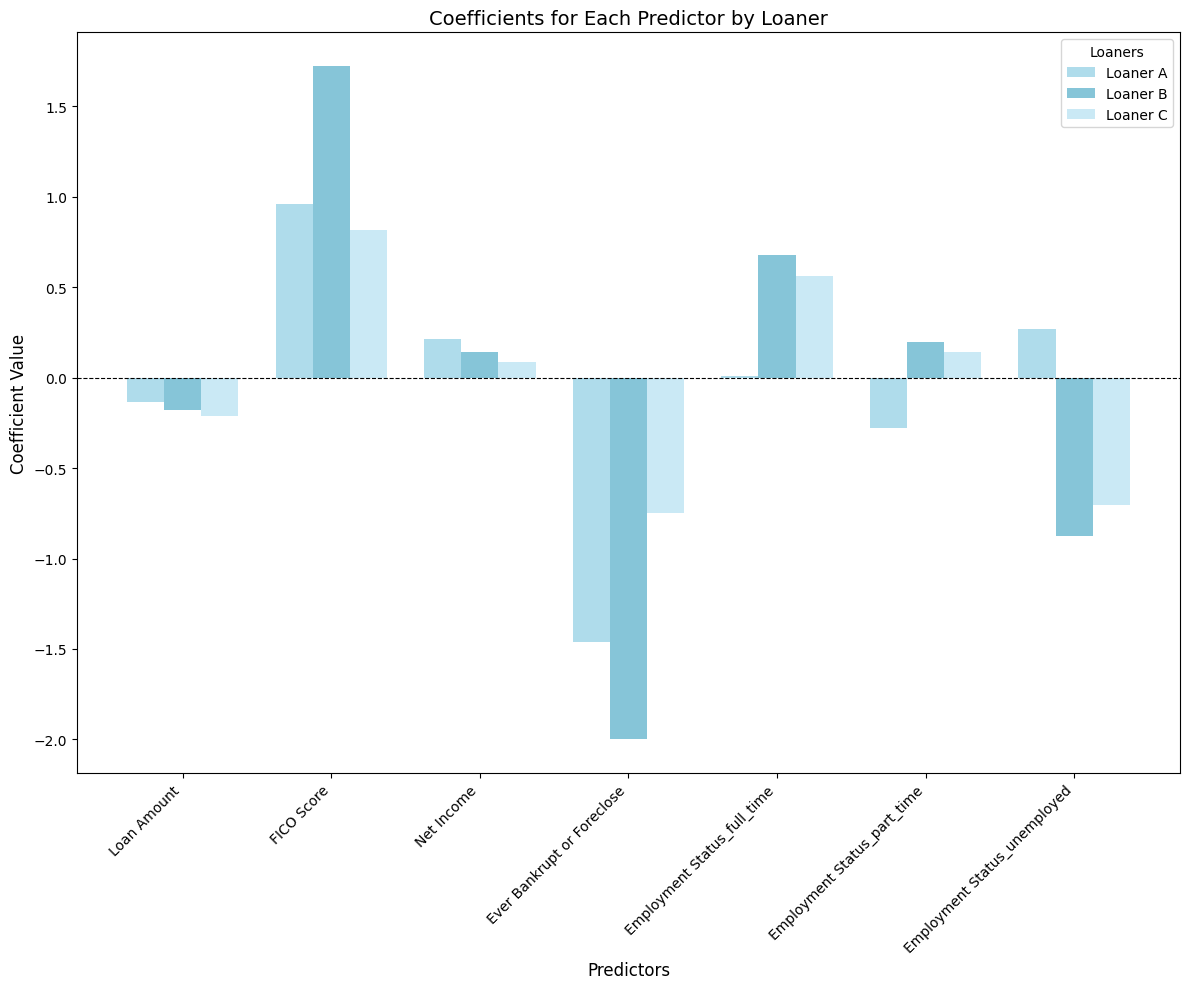

In [25]:
colors = {'A': '#AFDCEB', 'B': '#86C5D8', 'C': '#CAE9F5'}

coef_data = []
for loaner in loaners:
    model = models[loaner]
    coef_data.append(model.coef_[0])
    
coef_data = np.array(coef_data)  
x = np.arange(len(features)) 
width = 0.25 

fig, ax = plt.subplots(figsize=(12, 10))


for i, loaner in enumerate(loaners):
    ax.bar(x + i * width, coef_data[i], width, label=f'Loaner {loaner}', color=colors[loaner])

ax.set_xlabel('Predictors', fontsize=12)
ax.set_ylabel('Coefficient Value', fontsize=12)
ax.set_title('Coefficients for Each Predictor by Loaner', fontsize=14)
ax.set_xticks(x + width)
ax.set_xticklabels(features, rotation=45, ha='right')
ax.legend(title='Loaners')
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')  

plt.tight_layout()
plt.show()

In the graph above, we have each predictor on the x-axis, each with three bars measuring their coefficient values in each of the three models.

For FICO Score and Ever Bankrupt or Foreclose, the coefficients are strongest for Loaner B then A then C (in order of the revenue per approval amounts). This suggests that for stricter loans (loaner B with the lowest approval rate), these variables matter the most for approval, whether positively or negatively.

The other variables are not nearly as strong as the previously mentioned two, but in general the coefficients for loaner B are greater than that of loaner C, suggesting similar things as with FICO and Bankruptcy. 

An interesting couple things to note are how for Employment Status, loaner A seems to experience the opposite effect as the other two loaners. For example, while probability for getting approved from loaner B or C are lessened when you are unemployed, it is actually slightly improved for loaner A. Meanwhile, this effect is observed in the opposite effect for part timers, where part time customers are penalized when applying for a loan for lender A. One interpretation is that loaner A is targeted for unemployed customers. But this is contradicted by the fact that Net income and FICO score are positively influential for getting approved for loan A. So, it's possible that loaner A's approval process is more complex than what a logistic regression could capture.

## Conclusion and Potential Next Steps
As demonstrated by the potential increase in revenue and approval rate, this proposed matching system can dramatically improve Bankrate's ability to correctly match their customers with the appropriate loaner, as well as to maximize revenue based on historical data that is easily capturable.

This system could also possibly be further optimized with a few tweaks:
    1. Experimentation with more complex machine learning models. As mentioned before, it's possible that loaner A's approval process is more complicated than what a logistic regression can capture. In this case, a more complex model may be better suited, but with the cost of more computational power, which can decrease overall revenue for the company.
    2. If data exists on job stability between job industries, this data could be merged with the current dataset and used as a significant predictor of approvability. This is due to the fact that loans are paid in the long term, so stability of income is important in determining whether or not a customer can pay off their loan.
    3. A hard filter could be introduced before running the models to avoid expensive computations, especially when experimenting with more complex machine learning models. For example, if a customer was ever bankrupt or foreclosed their home, they wouldn't be considered for loaner B.

With these steps, the proposed system could become even better than now, driving more revenue increase and approval rate improvement, making Bankrate all the more profitable and reliable.